# Import libraries for analysis

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics

#Light GBM
import lightgbm as lgb


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

PATH = '/media/maria/2TB Monster driv/PrecisionFDA/'
PATH_Hospitalized = '/media/maria/2TB Monster driv/PrecisionFDA/LightGBM/DaysHospitalized/'

# Read train and test data

In [2]:
train = pd.read_csv(PATH + 'Descriptive/train.csv')
test = pd.read_csv(PATH + 'Descriptive/test.csv')

In [3]:
nohospitalized  = pd.read_csv(PATH_Hospitalized + 'lightgbm_hospitalized_status.csv') 

In [4]:
train.shape

(117959, 945)

In [5]:
train = train.loc[~pd.isna(train['Days_hospitalized'])]
train.shape

(20402, 945)

In [6]:
#train['Days_hospitalized'] = train['Days_hospitalized'].fillna(0) 

In [7]:
#To save the predictions of the folds
oof_df = train[["Id", "Days_hospitalized"]]

In [8]:
#Display all database

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [9]:
train['Days_hospitalized'].describe()

count    20402.000000
mean        12.620285
std          4.946833
min          1.000000
25%          8.252257
50%         13.296181
75%         16.329167
max         21.498611
Name: Days_hospitalized, dtype: float64

In [10]:
#Patients that did not get hospitalized should have LOS of zero

In [11]:
display_all(train.describe())

DRIVERS  PASSPORT           LAT           LON  HEALTHCARE_EXPENSES  \
count  20402.0   20402.0  20402.000000  20402.000000         2.040200e+04   
mean       1.0       1.0     42.275461    -71.351122         1.087820e+06   
std        0.0       0.0      0.280650      0.593072         5.345845e+05   
min        1.0       1.0     41.242040    -73.490615         5.244150e+03   
25%        1.0       1.0     42.124823    -71.526088         7.035057e+05   
50%        1.0       1.0     42.317243    -71.153259         1.279862e+06   
75%        1.0       1.0     42.455542    -71.021795         1.493375e+06   
max        1.0       1.0     42.896992    -69.927705         3.203008e+06   

       HEALTHCARE_COVERAGE           Age  Allergy to bee venom  \
count         2.040200e+04  20402.000000           2058.000000   
mean          3.044482e+04     58.938241              0.173955   
std           7.369992e+04     17.553300              0.379163   
min           0.000000e+00     21.000000              0.000000   
25%           6.402702e+03     47.000000              0.000000   
50%           1.110707e+04     62.000000              0.000000   
75%           2.087460e+04     74.000000              0.000000   
max           1.557373e+06     84.000000              1.000000   

       Allergy to dairy product  Allergy to eggs  Allergy to fish  \
count               2058.000000      2058.000000      2058.000000   
mean                   0.037901         0.043732         0.167153   
std                    0.191003         0.204547         0.373203   
min                    0.000000         0.000000         0.000000   
25%                    0.000000         0.000000         0.000000   
50%                    0.000000         0.000000         0.000000   
75%                    0.000000         0.000000         0.000000   
max                    1.000000         1.000000         1.000000   

       Allergy to grass pollen  Allergy to mould  Allergy to nut  \
count              2058.000000       2058.000000     2058.000000   
mean                  0.267250          0.397473        0.190962   
std                   0.442631          0.489494        0.393155   
min                   0.000000          0.000000        0.000000   
25%                   0.000000          0.000000        0.000000   
50%                   0.000000          0.000000        0.000000   
75%                   1.000000          1.000000        0.000000   
max                   1.000000          1.000000        1.000000   

       Allergy to peanuts  Allergy to soya  Allergy to tree pollen  \
count         2058.000000      2058.000000             2058.000000   
mean             0.197765         0.016035                0.264334   
std              0.398411         0.125640                0.441085   
min              0.000000         0.000000                0.000000   
25%              0.000000         0.000000                0.000000   
50%              0.000000         0.000000                0.000000   
75%              0.000000         0.000000                1.000000   
max              1.000000         1.000000                1.000000   

       Allergy to wheat  Dander (animal) allergy  House dust mite allergy  \
count       2058.000000              2058.000000              2058.000000   
mean           0.041302                 0.351798                 0.265792   
std            0.199037                 0.477647                 0.441861   
min            0.000000                 0.000000                 0.000000   
25%            0.000000                 0.000000                 0.000000   
50%            0.000000                 0.000000                 0.000000   
75%            0.000000                 1.000000                 1.000000   
max            1.000000                 1.000000                 1.000000   

       Latex allergy  Shellfish allergy  Agreeing on diabetes care plan  \
count    2058.000000        2058.000000                    19399.000000   
mean    

# Hyperparameters for LightGBM

In [12]:
seed = 42
#Using the parameters from a similar project on ICU mortality 

param = {'num_leaves': 15,
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'colsample_bytree':0.6189140385454879,
        'max_child_samples': 254,
        'min_child_weight': 0.001,
        'subsample': 0.7098267979279573,
        'reg_alpha': 5, 
        'reg_lambda': 1, 
        'scale_pos_weight': 1,
        'save_binary': True,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'regression',  #tweedie because zero inflated #regression
        #'tweedie_variance_power' : 1, #default 1.5, 1 close to poisson, 2 closer to gamma
        'verbose': 1,
        'metric': {'rmse'},
        'is_unbalance': False, 
        'boost_from_average': True,
        'extra_trees': True
    }

In [13]:
##concatenate train and test to get dummies and not get error
#train['is_train'] = 1
#test['is_train'] = 0
#train_test = pd.concat([train, test], axis = 0)
#display_all(train_test.head())

In [14]:
train.drop(columns=['COVID_Status', 'Hospitalized', 'Ventilator', 'ICU', 'Id', 'Days_ICU', 'Death'], inplace=True)  

In [15]:
predictors_int = list(train.columns)

In [16]:
cat_names = ['MARITAL', 'RACE', 'ETHNICITY',
             'GENDER', 'COUNTY', 'PLACE_BIRTH']

In [17]:
predictors_int.remove('MARITAL')
predictors_int.remove('RACE')
predictors_int.remove('ETHNICITY')
predictors_int.remove('GENDER')
predictors_int.remove('COUNTY')
predictors_int.remove('PLACE_BIRTH')


In [18]:
#Concatenate train and test to not get error when creating dummies or missing data
train['is_train'] = 1
test['is_train'] = 0
train_test = pd.concat([train, test], axis = 0, sort=False)


In [19]:
train_test.shape

(49894, 940)

In [20]:
#one-hot encoding of categorical variables
train_test = pd.get_dummies(train_test, columns = cat_names, dummy_na=True)

In [21]:
train = train_test.loc[train_test.is_train==1]
test = train_test.loc[train_test.is_train==0]

In [22]:
train.shape

(20402, 997)

In [23]:
train = train.drop(columns=['is_train'])

In [24]:
test = test.drop(columns=['is_train', 'Id'])

In [25]:
predictors = list(train.columns)
predictors.remove('Days_hospitalized')
predictors.remove('Id')

# LightGBM Model

In [26]:

nfold = 5
target = 'Days_hospitalized' 
skf = KFold(n_splits=nfold, shuffle=True, random_state=2019)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

In [27]:
len(oof)

20402

In [28]:

i = 1

for train_index, valid_index in skf.split(train, train.Days_hospitalized.values):
    print("\nfold {}".format(i))
    print(len(valid_index))
    
    #Train data
    t=train.iloc[train_index]
        
    xg_train = lgb.Dataset(t[predictors].values,
                           label=t[target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )
    
    xg_valid = lgb.Dataset(train.iloc[valid_index][predictors].values,
                           label=train.iloc[valid_index][target].values,
                           feature_name=predictors,
                           free_raw_data = False
                           )   

    num_rounds = 2000
    clf = lgb.train(param, xg_train, num_rounds, valid_sets = [xg_train, xg_valid], 
                    verbose_eval=2000, early_stopping_rounds = 100) #1000
    oof[valid_index] = clf.predict(train.iloc[valid_index][predictors].values, num_iteration=clf.best_iteration) 
    #save models
    clf.save_model('lgb_classifier_fold{}.txt'.format(i), num_iteration=clf.best_iteration) 
    #to read model model = lgb.Booster(model_file='lgb_classifier.txt')
    predictions += clf.predict(test[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1



fold 1
4081
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[536]	training's rmse: 4.30236	valid_1's rmse: 4.45022

fold 2
4081
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[590]	training's rmse: 4.29568	valid_1's rmse: 4.4029

fold 3
4080
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[527]	training's rmse: 4.28319	valid_1's rmse: 4.5269

fold 4
4080
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[931]	training's rmse: 4.19634	valid_1's rmse: 4.50705

fold 5
4080
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[758]	training's rmse: 4.24967	valid_1's rmse: 4.4307


# Metrics Analysis

In [29]:
graph = lgb.create_tree_digraph(clf)
graph.render(view=True)

'Digraph.gv.pdf'

In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(train.Days_hospitalized.values, oof))

In [31]:
rms

4.4637948136567625

# Save Predictions and OOF

In [32]:
sub_df = pd.read_csv(PATH + 'Descriptive/test.csv')
sub_df["Days_hospitalized"] = predictions


In [33]:
#nohospitalized["Hospitalized_flag"] = 0
#sub_df["Days_hospitalized"] = sub_df["Days_hospitalized"] * sub_df["Hospitalized_flag"]

sub_df = sub_df.merge(nohospitalized, left_on='Id', right_on ='Id')

In [34]:
sub_df['Hospitalized_flag'] = (sub_df['Hospitalized'] != 0)* 1

In [35]:
sub_df['Days_hospitalized'] = sub_df['Hospitalized_flag'] * sub_df['Days_hospitalized']

In [36]:
sub_df[['Id', 'Days_hospitalized']].to_csv("lightgbm_Hospitalized.csv", index=False, line_terminator='\n', header=False)


In [37]:
np.mean(sub_df['Days_hospitalized'])

3.9351602674723165

In [38]:
len(oof)

20402

In [39]:
train.shape

(20402, 996)

In [40]:
oof_df.loc[:,"LGBM"] = oof
oof_df[:10]

,Id,Days_hospitalized,LGBM
4,26e5d262-6cdc-4274-a5cd-d7fd439e35f9,17.303472,14.232476
5,90031c21-e8a4-416e-b60b-23e871ee62dc,20.324306,14.132582
12,c58ae02e-235e-4db2-a9c3-6926e9c0c5fa,4.122917,12.516527
13,0e07d4b4-8c0a-4cd0-a439-8f3b96ab884d,20.320833,14.525776
30,ef272f3c-6cbd-401c-97b5-db5de666b6e5,20.027778,14.875194
32,8173a76b-72b9-4661-bee3-fb970b46c466,19.369444,14.194884
38,52e1f151-e98b-4163-a250-5e7d5c6ff813,7.194444,13.645225
45,dc88a3e8-716c-42b0-8953-08727552c9ab,13.059722,13.001797
47,850b2ad9-ebf2-4f26-bd12-d041791ec3e2,19.386111,9.559668
48,223e4aec-a073-4599-8efe-a18af14610fa,12.120139,14.445182


In [41]:
oof_df.to_csv("Ooflightgbm.csv", index=False)

# Explainability

In [42]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.pipeline import make_pipeline

In [43]:
#https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html#simple-xgboost-classifier

In [44]:
import seaborn as sns

In [45]:
imp_df = pd.DataFrame()
imp_df['feature'] = predictors
imp_df['gain']  = clf.feature_importance(importance_type='gain')
imp_df['split'] = clf.feature_importance(importance_type='split')

In [46]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

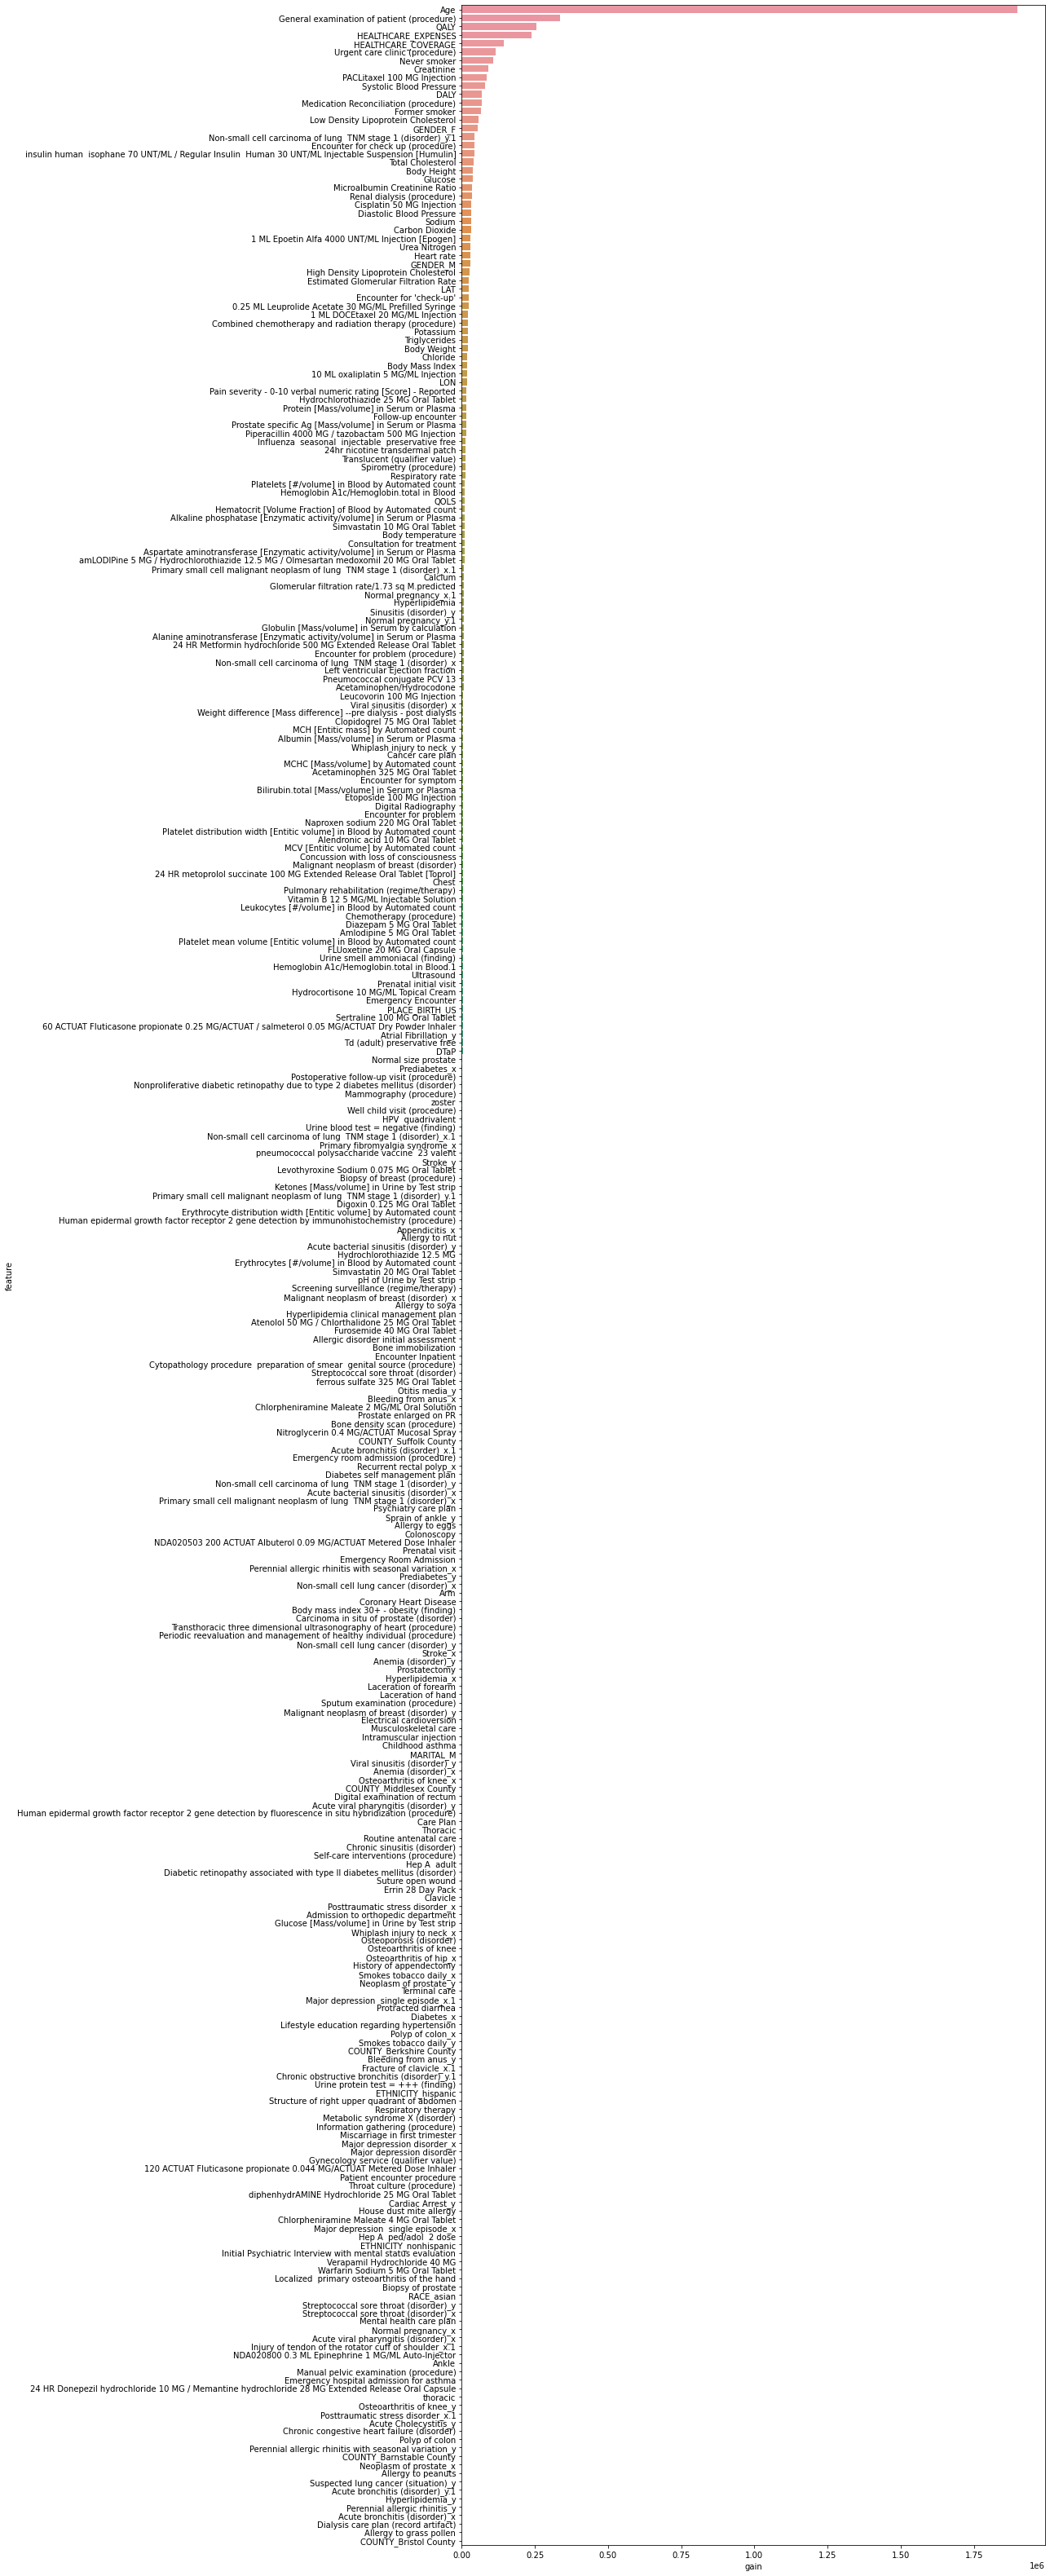

In [47]:
plot_importances(imp_df)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


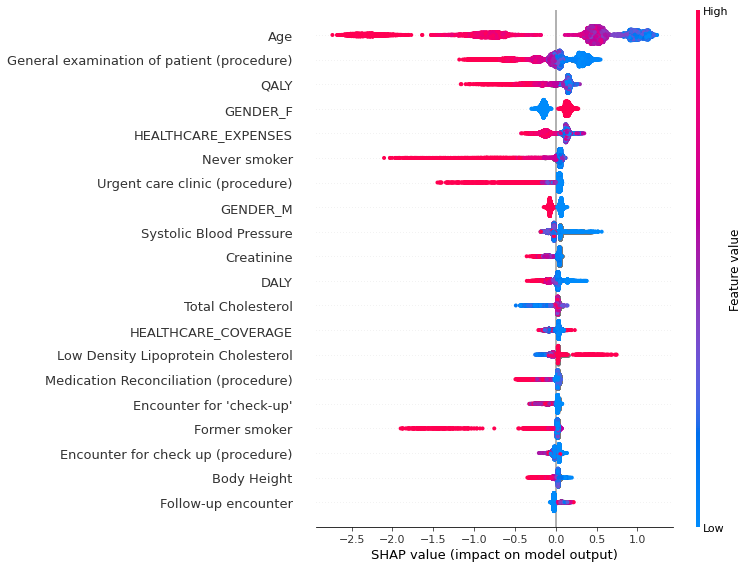

In [48]:
import shap
explainer   =  shap.TreeExplainer(clf)
shap_values = explainer.shap_values(t[predictors])
shap.summary_plot(shap_values, t[predictors])

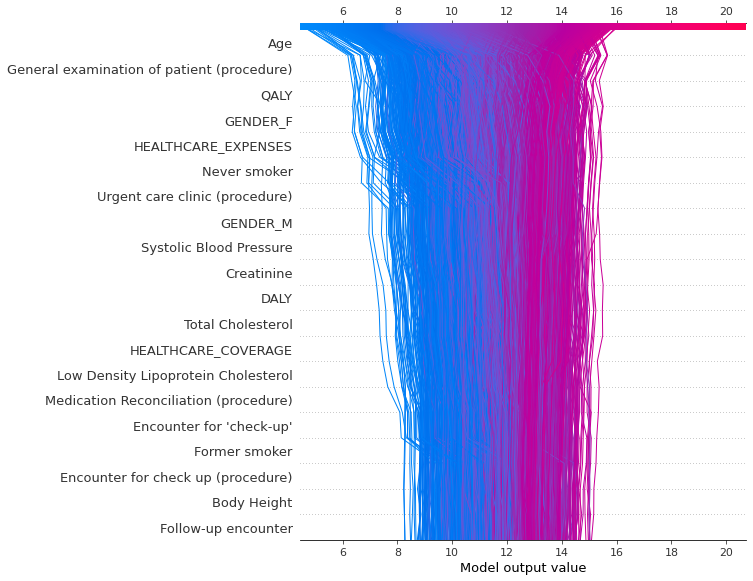

In [49]:
shap.decision_plot(explainer.expected_value, shap_values, predictors, ignore_warnings=True,
                  legend_labels=None)

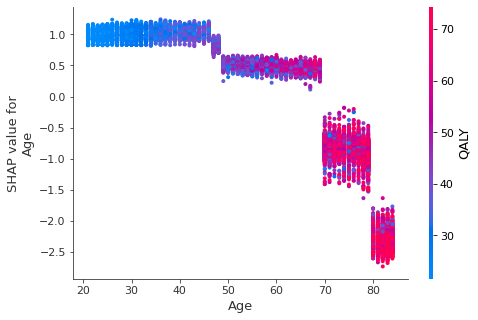

In [50]:
shap.dependence_plot('Age', shap_values, t[predictors], interaction_index='QALY')

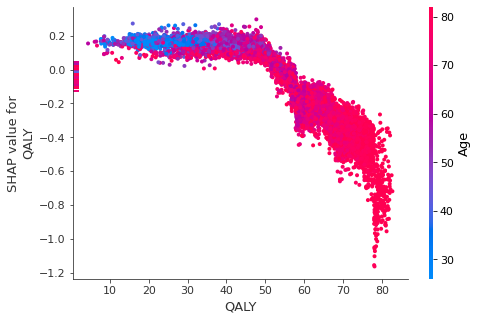

In [51]:
shap.dependence_plot('QALY', shap_values, t[predictors], interaction_index='Age')